# Patch NN approach

In [ ]:
from bs4                     import BeautifulSoup
import matplotlib.pyplot     as plt
import matplotlib.image      as mpimg
import numpy                 as np
import skimage.transform
import dicom
import glob
import model
import scipy.misc
import os
import h5py
import json
import pylab

data_filepath = "/enc_data/eddata/pacemaker/"
ann_filepath = data_filepath + "ann/"
img_filepath = data_filepath + 'organized-data/'
png_filepath = data_filepath + 'png/'

SIZE_X = 726
SIZE_Y = 726
VGG_DIMS = (224, 224)

In [45]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import current
from IPython.core.interactiveshell import InteractiveShell


def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path


class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = current.read(f, 'json')


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.worksheets[0].cells:
                if cell.cell_type == 'code' and cell.language == 'python':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.input)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod


class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

/usr/local/lib/python2.7/dist-packages/nbformat/current.py:19: UserWarning: nbformat.current is deprecated.

- use nbformat for read/write/validate public API
- use nbformat.vX directly to composing notebooks of a particular version

  """)


In [46]:
import vgg

importing Jupyter notebook from vgg.ipynb


## Patch sizes

In [15]:
# Returns the dimensions of the box as: 
#     (x_min, x_max, y_min, y_max)
def get_box(filename): 
    with open(ann_filepath + filename, 'r') as f: 
        soup = BeautifulSoup(f, 'xml')
        
        box = soup.bndbox
        return (int(box.xmin.string), int(box.xmax.string), int(box.ymin.string), int(box.ymax.string))

print get_box('2620820_6565471-2169-11-22-1313-ANTERO-POSTERIOR.xml')

(1901, 2451, 699, 1245)


In [16]:
def get_x_size(box): 
    return box[1] - box[0]

def get_y_size(box): 
    return box[3] - box[2]

def get_center(box): 
    x_center = np.mean([box[0], box[1]])
    y_center = np.mean([box[2], box[3]])
    return (x_center, y_center)

box = get_box('2620820_6565471-2169-11-22-1313-ANTERO-POSTERIOR.xml')
x_size = get_x_size(box)
y_size = get_y_size(box)

print x_size, y_size
print get_center(box)

550 546
(2176.0, 972.0)


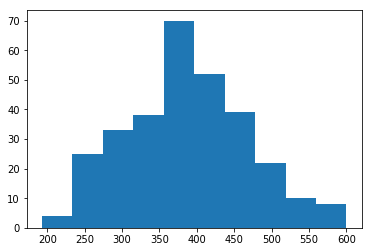

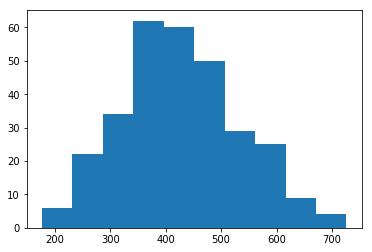

600 726


In [63]:
def get_sizes(): 
    x_sizes, y_sizes = [], []
    
    for dicom_file in os.listdir(ann_filepath): 
        if not dicom_file.endswith('.xml'): 
            continue
        
        try: 
            box = get_box(dicom_file)
            x_size = get_x_size(box)
            y_size = get_y_size(box)

            x_sizes.append(x_size)
            y_sizes.append(y_size)
            
        except Exception as e: 
            print dicom_file, e
    
    return x_sizes, y_sizes

x_sizes, y_sizes = get_sizes()
plt.hist(x_sizes)
plt.show()
plt.hist(y_sizes)
plt.show()

x_size = np.max(x_sizes)
y_size = np.max(y_sizes)

print x_size, y_size

## Visualize patches

In [19]:
# Assumes filename is given as patientid_clipnum.dcm
def get_dicom_array(filename): 
    patient_id = filename.split("_")[0]
    clipnum = filename.split("_")[1].split(".")[0] + ".dcm"
    
    dc_array = dicom.read_file(img_filepath + patient_id + "/" + clipnum).pixel_array
    return dc_array    

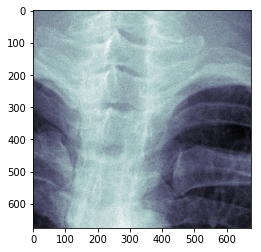

In [20]:
def save_image(array, filename): 
    scipy.misc.imsave(filename, array)
    
def plot_image(filename): 
    img = mpimg.imread(filename)
    plt.imshow(img, cmap=pylab.cm.bone)
    plt.show()
    
plot_image(png_filepath + 'neg/839798_7044227-2186-04-06-1310-POSTERO-ANTERIOR.png')

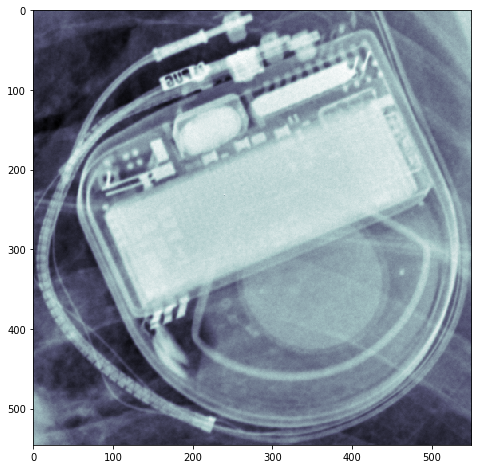

In [21]:
def get_pacemaker_array(filename, rotate=0): 
    box = get_box(filename)
    
    dc_array = get_dicom_array(filename)
    pacemaker_array = dc_array[box[2]:box[3],box[0]:box[1]]
    
    pacemaker_array = np.rot90(pacemaker_array, k=rotate)
    
    return pacemaker_array
    
pacemaker = get_pacemaker_array('2620820_6565471-2169-11-22-1313-ANTERO-POSTERIOR.xml')
plt.figure(figsize=[8,8])
plt.imshow(pacemaker, cmap=pylab.cm.bone)
plt.show()

In [22]:
def get_bounds(center_dim, size, max_size): 
    dim_min = center_dim - size / 2
    dim_max = center_dim + (size - size / 2)
    
    if dim_min < 0: 
        dim_min = 0
        dim_max = size
    if dim_max >= max_size: 
        dim_max = max_size - 1
        dim_min = max_size - 1 - size
    
    return int(dim_min), int(dim_max)

def get_max_box(filename): 
    box = get_box(filename)
    img_dims = get_dicom_array(filename).shape

    center = get_center(box)
    x_min, x_max = get_bounds(center[0], SIZE_X, img_dims[1])
    y_min, y_max = get_bounds(center[1], SIZE_Y, img_dims[0])
    
    return (x_min, x_max, y_min, y_max)

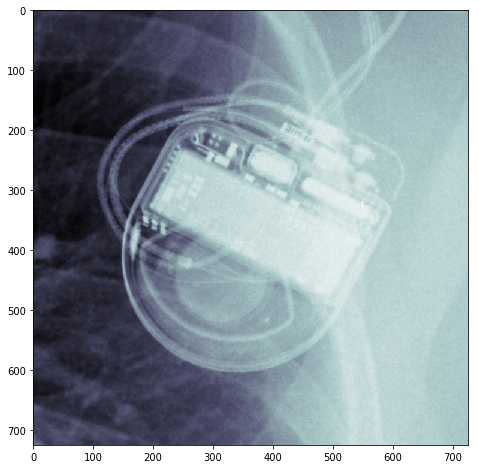

In [23]:
# Normalize to a specific size (the maximum patch size)
def get_max_pacemaker_array(filename): 
    max_box = get_max_box(filename) 
    
    dc_array = get_dicom_array(filename)
    max_pacemaker_array = dc_array[max_box[2]:max_box[3],max_box[0]:max_box[1]]
    
    return max_pacemaker_array

# pacemaker = get_max_pacemaker_array('2620820_6565471-2169-11-22-1313-ANTERO-POSTERIOR.xml')
pacemaker = get_max_pacemaker_array('2367704_6062255-2193-05-22-1716-POSTERO-ANTERIOR.xml')
plt.figure(figsize=[8,8])
plt.imshow(pacemaker, cmap=pylab.cm.bone)
plt.show()

## Save all patches

In [64]:
for ann_file in os.listdir(ann_filepath): 
    if not ann_file.endswith('.xml'): 
        continue
    
    try: 
        pacemaker = get_max_pacemaker_array(ann_file)

        save_filename = png_filepath + "pacemaker/max_size/" + ann_file.split('.')[0] + ".png"
        save_image(pacemaker, save_filename)

    except Exception as e: 
        print ann_file, e

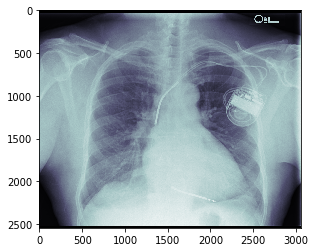

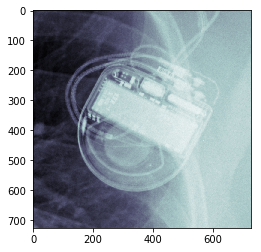

In [25]:
plot_image(png_filepath + 'full_image/2367704_6062255-2193-05-22-1716-POSTERO-ANTERIOR.png')
plot_image(png_filepath + 'pacemaker/max_size/2367704_6062255-2193-05-22-1716-POSTERO-ANTERIOR.png')

## Generate neg boxes

In [26]:
def get_neg_box(array): 
    dims = array.shape
    x_bound = dims[1] - SIZE_X
    y_bound = dims[0] - SIZE_Y
    
    rand_x = np.random.randint(x_bound)
    rand_y = np.random.randint(y_bound)
    
    return (rand_x, rand_x + SIZE_X, rand_y, rand_y + SIZE_Y)

In [65]:
# with open(data_filepath + "regex_ann/neg.json", 'r') as f: 
#     neg = json.load(f)
    
# i = 0
# for num in range(400): 
#     patient_id = neg[i]
    
#     for dicom_file in glob.glob(img_filepath + patient_id + "/"+ '*.dcm'): 
#         if "lateral" in dicom_file.lower(): 
#             continue
            
#         png_filename = dicom_file.lstrip(img_filepath).strip('.dcm').replace("/", '_') + ".png"
#         save_filepath = png_filepath + "neg/" + png_filename

#         dc_array = dicom.read_file(dicom_file).pixel_array
#         neg_box = get_neg_box(dc_array)
#         neg_array = dc_array[neg_box[2]:neg_box[3],neg_box[0]:neg_box[1]]
                
#         save_image(neg_array, save_filepath)
#         break
        
#     i += 1

/enc_data/eddata/pacemaker/png/


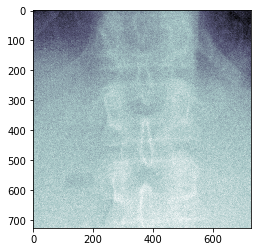

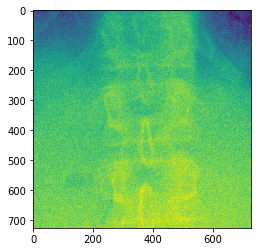

In [68]:
print png_filepath
plot_image(png_filepath + 'neg/839798_7044227-2186-04-06-1310-POSTERO-ANTERIOR.png')

img = plt.imread(png_filepath + 'neg/839798_7044227-2186-04-06-1310-POSTERO-ANTERIOR.png')
plt.imshow(img)
plt.show()

## Load data

In [2]:
def resize(image):
    """ Resizes the image into dimensions specified by dims and converts img to 3 channels """
    newimg = skimage.transform.resize(image, VGG_DIMS)
    
    # Convert from 1 channel to 3 channels
    newimg_3d = np.empty(VGG_DIMS + (3,))
    for i in range(3):
        newimg_3d[:,:,i] = newimg
        
    return newimg_3d

def load_images(path, number):
    """ Path: Path to .png images
        Number: Number of images to run
        Dims: (height, width) of the final images that will be fed into the model """
    
    return np.array([ resize(plt.imread(path + image_path)) for image_path in os.listdir(path)[:number] ])

In [3]:
pos_imgs = load_images(png_filepath + "pacemaker/max_size/", number=10)
print pos_imgs.shape

NameError: name 'png_filepath' is not defined

In [77]:
neg_imgs = load_images(png_filepath + "neg/", number=10)
print neg_imgs.shape

(10, 224, 224, 3)


In [78]:
np.concatenate((pos_imgs, neg_imgs)).shape

(20, 224, 224, 3)

In [79]:
X = np.concatenate((pos_imgs, neg_imgs))
Y = np.array([1] * pos_imgs.shape[0] + [0] * neg_imgs.shape[0])
print X.shape, Y.shape

(20, 224, 224, 3) (20,)


## Train model

importing Jupyter notebook from vgg.ipynb
('Train shape: ', (12, 224, 224, 3), (12,))
('Val shape: ', (4, 224, 224, 3), (4,))
('Test shape: ', (4, 224, 224, 3), (4,))
[1 0 1 1 0 1 0 1 0 1 0 0]
pacemaker


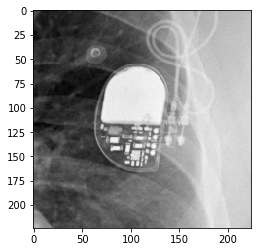

not


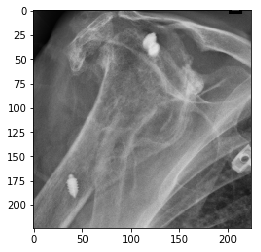

pacemaker


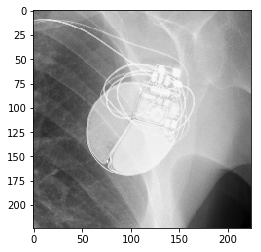

pacemaker


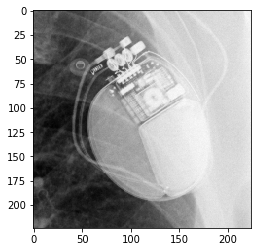

not


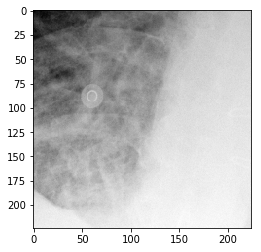

pacemaker


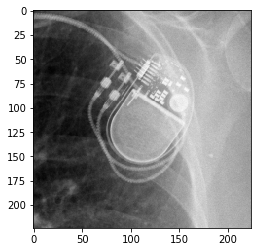

not


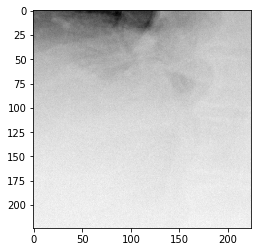

pacemaker


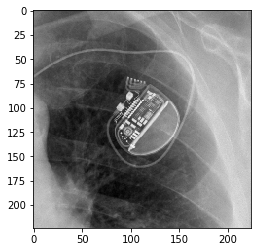

not


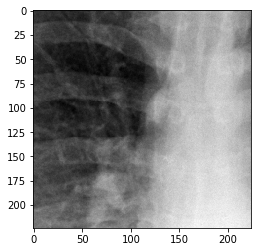

pacemaker


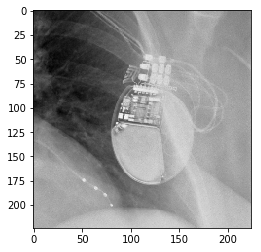

not


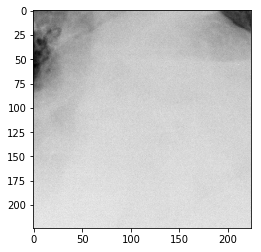

not


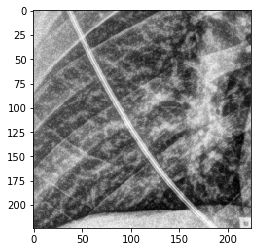

('y_train, y_val, y_test: ', (12, 2), (4, 2), (4, 2))
Epoch 1/1
1/1 [==============================] - 12s 12s/step - loss: 0.8538 - acc: 0.3750 - val_loss: 0.7560 - val_acc: 0.3750
('Test loss: ', 0.71001460485988188, ' Accuracy: ', 0.5)


In [86]:
import vgg
reload(vgg)
vgg.run(X, Y, 'results/num300_epochs1_12layers_onlypos.pkl', 'results/num300_epochs1_12layers_onlypos.h5', batch_size=8, num_epochs=1)

## Run on pacemaker images

In [14]:
def get_pacemaker_patch(model, pixel_array, hop_x, hop_y):
    for x in range(0, pixel_array.shape[1], hop_x): 
        for y in range(0, pixel_array.shape[0], hop_y): 
            subarray = pixel_array[y:y+SIZE_Y, x:x+SIZE_X]
            # TODO: Resize subarray to appropriate size
            
            # TODO: Run the model to see if the the subarray is classified as a pacemaker or not
            if model.is_pacemaker(subarray): 
                return (x, x+SIZE_X, y, y+SIZE_Y)

## Run on overall images

In [ ]:
true, false = [], []

for filename in os.listdir(...): 
    pixel_array = filename.pixel_array
    if contains_pacemaker(pixel_array, SIZE_X / 4, SIZE_Y / 4): 
        